In [1]:
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import os, sys
from glob import glob
from scipy.ndimage import gaussian_filter1d
from scipy.ndimage import gaussian_filter
import h5py
import quantities as pq
import seaborn as sns

sys.path.append('../scripts/')
sys.path.append('../scripts/icsd_scripts/')
from data_processing_before_lpa import *

from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

In [3]:
sim_data_dir = '../data/sim_data/'
fig_dir = 'Figures/test_notebooks'

In [4]:
# for plotting
plt.rcParams.update({'font.size': 16})

flash_types = ['white', 'black']

In [5]:
nchan_sim = 26                                        # Number of channels on probe in simulation

trial_dur_sim = 750                                     # Duration one trial (ms)
tstim_onset_sim = 250
tstim_onset_sim_dg = 500
trial_dur_sim_dg = 3000
ntrials_sim = 10                                        # Number of trials
t_rem_trial_start = 50

trial_dur_sim_corr = trial_dur_sim-t_rem_trial_start
tstim_onset_sim = tstim_onset_sim-t_rem_trial_start
tstim_onset_sim_dg = tstim_onset_sim_dg-t_rem_trial_start

channel = np.arange(nchan_sim)

## Load MUA from simulations

In [6]:
mua_sims_all_stim = dict()

#### Flashes

In [7]:
selected_sims_data_dir = os.path.join(sim_data_dir, '*full_model*')

mua_sims = find_files(selected_sims_data_dir, filename = 'mua_w_baseline.npy')

if len(mua_sims.keys()) == 1:
    sim_name = list(mua_sims.keys())[0]
elif len(mua_sims.keys()) > 1:
    sim_names = list(mua_sims.keys())
    sim_name = sim_names[0]
print(mua_sims.keys())

for sim_name in list(mua_sims.keys()):
    mua_sims_all_stim[sim_name] = mua_sims[sim_name]
    print(sim_name)

dict_keys(['full_model_white_flash', 'full_model_black_flash'])
full_model_white_flash
full_model_black_flash


### Splice

In [8]:
nchan_lim = 22

In [9]:
mua_sims_trial_avg = np.zeros((len(mua_sims_all_stim.keys()), nchan_lim, mua_sims_all_stim[sim_name]['trial_avg'].shape[1]))

for isim, sim_name in enumerate(mua_sims_all_stim.keys()):
    print(sim_name)
    mua_sims_trial_avg[isim] = mua_sims_all_stim[sim_name]['trial_avg'][:nchan_lim]

full_model_white_flash
full_model_black_flash


In [10]:
mua_sims_trial_avg = [[[]]*mua_sims_all_stim[sim_name]['trial_avg'].shape[0]]

for sim_name in mua_sims_all_stim.keys():
    print(sim_name)
    for ichan in range(mua_sims_all_stim[sim_name]['trial_avg'].shape[0]):
        if len(mua_sims_trial_avg[0][ichan]) == 0:
            mua_sims_trial_avg[0][ichan] = mua_sims_all_stim[sim_name]['trial_avg'][ichan]
        else:
            mua_sims_trial_avg[0][ichan] = np.concatenate([mua_sims_trial_avg[0][ichan], \
                                                 mua_sims_all_stim[sim_name]['trial_avg'][ichan]])

mua_sims_trial_avg = np.array(mua_sims_trial_avg)

full_model_white_flash
full_model_black_flash


In [11]:
layer_borders = np.array([0, 100, 310, 430, 650, 850])

### Supplementary figure: MUA Power across depth

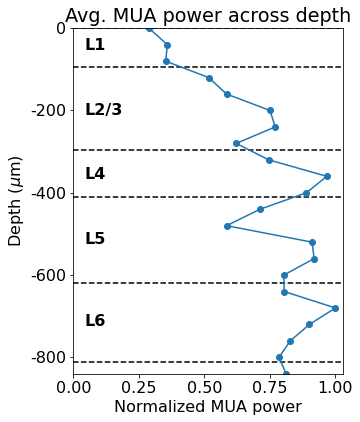

In [12]:
fig, ax = plt.subplots(figsize = (5,6))

avg_mua_power = np.mean(np.mean(mua_sims_trial_avg[:,:22], axis = 0), axis = -1)

avg_mua_power_norm = avg_mua_power/avg_mua_power.max()

chans = np.arange(len(avg_mua_power))

ax.plot(avg_mua_power_norm,chans, 'o-')

ax.invert_yaxis()
ax.set_ylabel('Depth ($\mu$m)')
ax.set_yticks(np.arange(0,25,5))
ax.set_yticklabels(-np.arange(0,1000,200))

ax.set_xlabel('Normalized MUA power')

for ilayer, border in enumerate(layer_borders):
    ax.hlines(y = border/880*(len(chans)-1), xmin = 0, xmax = 1.3, linestyle = '--')

ax.margins(x = 0, y = 0)

ax.set_xlim([0,1.03])

yshift = 0#1*0.242-1*0.0009
plt.figtext(x = 0.23, y = 0.85-yshift, s = 'L1', fontsize = 16, fontweight = 560)
plt.figtext(x = 0.23, y = 0.7-yshift, s = 'L2/3', fontsize = 16, fontweight = 560)
plt.figtext(x = 0.23, y = 0.55-yshift, s = 'L4', fontsize = 16, fontweight = 560)
plt.figtext(x = 0.23, y = 0.4-yshift, s = 'L5', fontsize = 16, fontweight = 560)
plt.figtext(x = 0.23, y = 0.21-yshift, s = 'L6', fontsize = 16, fontweight = 560)

ax.set_title('Avg. MUA power across depth')

fig.subplots_adjust(left = 0.2, right = 0.95, bottom = 0.1, top = 0.9)

fig_name = 'avg_mua_power_across_depth.png'

savepath = os.path.join(fig_dir.rsplit('/',1)[0], 'Supplementary_figures', fig_name)

#fig.savefig(savepath, facecolor = 'w')

### Spikes

- Load population spike trains from simulations of full-field flash stimulus presentations

In [13]:
timestamps_all_stim = dict()

In [14]:
timestamps_configs = find_all_fir_rates_files_sim(selected_sims_data_dir.rsplit('/', 1)[0], 'timestamps_with_neuron_ids*.npy')
sim_names = list(timestamps_configs.keys())
print(sim_names)
sim_name = sim_names[-1]

['full_model_white_flash', 'full_model_black_flash']


In [15]:
npop_guess = 5

In [16]:
sims_spike_trains_cell_pops = timestamps_to_spiketrains_sim(timestamps_configs, mode = 'only_exc_except_L1')


 full_model_white_flash
e23Cux2
e4Nr5a1
e4Rorb
e4Scnn1a
e4other
e5Rbp4
e5noRbp4
e6Ntsr1
i1Htr3a
i23Htr3a
Use only excitatory cells except for L1. Skip.
i23Pvalb
Use only excitatory cells except for L1. Skip.
i23Sst
Use only excitatory cells except for L1. Skip.
i4Htr3a
Use only excitatory cells except for L1. Skip.
i4Pvalb
Use only excitatory cells except for L1. Skip.
i4Sst
Use only excitatory cells except for L1. Skip.
i5Htr3a
Use only excitatory cells except for L1. Skip.
i5Pvalb
Use only excitatory cells except for L1. Skip.
i5Sst
Use only excitatory cells except for L1. Skip.
i6Htr3a
Use only excitatory cells except for L1. Skip.
i6Pvalb
Use only excitatory cells except for L1. Skip.
i6Sst
Use only excitatory cells except for L1. Skip.

 full_model_black_flash
e23Cux2
e4Nr5a1
e4Rorb
e4Scnn1a
e4other
e5Rbp4
e5noRbp4
e6Ntsr1
i1Htr3a
i23Htr3a
Use only excitatory cells except for L1. Skip.
i23Pvalb
Use only excitatory cells except for L1. Skip.
i23Sst
Use only excitatory cells except

In [ ]:
sims_spike_trains_layer_pops = spiketrains_by_layer(sims_spike_trains_cell_pops, npop_guess = npop_guess)

full_model_white_flash
e23Cux2 12689
e4Nr5a1 1248
e4Rorb 2605
e4Scnn1a 3072
e4other 3329
e5Rbp4 6010
e5noRbp4 1559
e6Ntsr1 12882
i1Htr3a 999
full_model_black_flash
e23Cux2 12689
e4Nr5a1 1248
e4Rorb 2605
e4Scnn1a 3072
e4other 3329


In [ ]:
fir_rate_all_trials = dict()
fir_rate_trial_avg = dict()

fir_rate_trial_avg_pops_temp = np.zeros((len(sims_spike_trains_layer_pops.keys()), npop_guess, 700))
for isim, sim_name in enumerate(sims_spike_trains_layer_pops.keys()):
    print(sim_name)
    for ipop, pop_name in enumerate(sims_spike_trains_layer_pops[sim_name].keys()):
        if ~np.any(sims_spike_trains_layer_pops[sim_name][pop_name]):
            continue
        print(pop_name)
        fir_rate_temp = np.mean(np.mean(sims_spike_trains_layer_pops[sim_name]\
                                            [pop_name][:,:,t_rem_trial_start:], axis = 0), axis = 0)
        
        fir_rate_trial_avg_pops_temp[isim, ipop] = fir_rate_temp
        

for ipop, pop_name in enumerate(sims_spike_trains_layer_pops[sim_name].keys()):
    print(pop_name)
    fir_rate_trial_avg[pop_name] = fir_rate_trial_avg_pops_temp[:, ipop]

## Load results from applying LPA to MUA with 5 populations assumed

In [ ]:
filename = 'lpa_on_sim_mua_5pops.npy'

loadpath = os.path.join('lpa_results_data', filename)

data_mua = np.load(loadpath, allow_pickle=True)[()]

In [ ]:
data_mua.keys()

In [ ]:
Mphi = data_mua['Mphi']
rmat = data_mua['rmat']
Mmat = data_mua['Mmat']

In [ ]:
Mphi.shape

### Plot total MUA estimated with LPA together with original simulated MUA

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols = 2, figsize = (9, 8), sharex = True, sharey = True)

scale_to_uV = 1E3
tstim_onset = 250

mua_rel_MSE = dict()
mua_est_corr = dict()

for istim, flash_type in zip(range(2), ['white', 'black']):
    ax = axes[0,istim]
    mua_sim_plot = mua_sims[sim_name]['trial_avg'][:nchan_lim]*scale_to_uV
    #mua_sim_plot = (mua_sim_orig.T-np.mean(mua_sim_orig[:,:tstim_onset_sim], axis = 1)).T
    cmap_range = np.abs(mua_sim_plot).max()/3
    ax.imshow(mua_sim_plot, aspect='auto', vmin = 0, vmax = cmap_range)

    if istim == 0:
        ax.set_ylabel('Depth ($\mu$m)')
    ax.set_yticks(np.arange(0,25+5,5))
    ax.set_yticklabels(-np.arange(0,1000+200,200))

    ax.set_title('MUA from simulation')

    ax = axes[1,istim]

    mua_lpa_plot = Mphi[istim].T*scale_to_uV
    #mua_lpa_plot = (mua_lpa_orig.T-np.mean(mua_lpa_orig[:,:tstim_onset_sim], axis = 1)).T
    im = ax.imshow(mua_lpa_plot, aspect = 'auto', vmin = 0, vmax = cmap_range)
    
    diff = mua_lpa_plot-mua_sim_plot
    rel_MSE = np.sum(diff**2)/np.sum(mua_sim_plot**2)
    
    corr = np.corrcoef(mua_sim_plot.flatten(), mua_lpa_plot.flatten())[0,1]
    
    mua_rel_MSE[flash_type] = rel_MSE
    mua_est_corr[flash_type] = corr
    
    print(sim_name, corr)
    print(sim_name, rel_MSE)

    ax.set_title('LPA-estimated MUA')
    
    if istim == 0:
        ax.set_ylabel('Depth ($\mu$m)')
        
    ax.set_xlim([0,700])
        
    axes[istim, 0].hlines(y = mua_sim_plot.shape[0]-0.9, xmin = 0, xmax = tstim_onset-50, colors = 'gray', linewidth = 8.0)
    axes[istim, 0].hlines(y = mua_sim_plot.shape[0]-0.9, xmin = tstim_onset-50, xmax = tstim_onset+250-50, colors = 'white', linewidth = 8.0)
    axes[istim, 0].hlines(y = mua_sim_plot.shape[0]-0.9, xmin = tstim_onset+250-50, xmax = 700, colors = 'gray', linewidth = 8.0)

    axes[istim, 1].hlines(y = mua_sim_plot.shape[0]-0.9, xmin = 0, xmax = tstim_onset+250-50, colors = 'gray', linewidth = 8.0)
    axes[istim, 1].hlines(y = mua_sim_plot.shape[0]-0.9, xmin = tstim_onset-50, xmax = tstim_onset+250-50, colors = 'black', linewidth = 8.0)
    axes[istim, 1].hlines(y = mua_sim_plot.shape[0]-0.9, xmin = tstim_onset+250-50, xmax = 700, colors = 'gray', linewidth = 8.0)
        
ax.set_xticks(np.arange(0,mua_lpa_plot.shape[1],200))
ax.set_xticklabels(np.arange(0,mua_lpa_plot.shape[1],200)-200)

plt.figtext(s = 'Time from stimulus onset (ms)', y = 0.02, x = 0.3)

plt.figtext(s = 'White Flash', y = 0.93, x = 0.18, fontsize = 22)
plt.figtext(s = 'Black Flash', y = 0.93, x = 0.58, fontsize = 22)

cbaxes = fig.add_axes([0.87,0.37,0.01, 0.25])
cb = fig.colorbar(im, ax = ax, cax = cbaxes)
cb.set_label('MUA ($\mu$V)')

for i in range(2):
    plt.figtext(x = 0.11, y = 0.84-i*0.43, s = 'L1', fontsize = 21, fontweight = 560)
    plt.figtext(x = 0.11, y = 0.775-i*0.43, s = 'L2/3', fontsize = 21, fontweight = 560)
    plt.figtext(x = 0.11, y = 0.71-i*0.43, s = 'L4', fontsize = 21, fontweight = 560)
    plt.figtext(x = 0.11, y = 0.64-i*0.43, s = 'L5', fontsize = 21, fontweight = 560)
    plt.figtext(x = 0.11, y = 0.565-i*0.43, s = 'L6', fontsize = 21, fontweight = 560)

fig.subplots_adjust(wspace = 0.15, left = 0.11, right = 0.85, bottom = 0.09, top = 0.88)

fig_name = 'mua_total_compare_sim_and_LPA_both_flashes.png'
savepath = os.path.join(fig_dir, 'MUA')
    
if not os.path.exists(savepath):
    if not os.path.exists(savepath.rsplit('/', 1)[0]):
        os.mkdir(savepath.rsplit('/', 1)[0])
        os.mkdir(savepath)
    else:
        os.mkdir(savepath)

savepath = os.path.join(savepath, fig_name)
#fig.savefig(savepath, facecolor = 'w')

## Plot metrics: Correlation and relative MSE between LPA-estimated total MUA and original simulated MUA

In [ ]:
mua_total_metrics_mat = np.zeros((2,2))

mua_total_metrics_mat[:,0] = np.array(list(mua_rel_MSE.values()))
mua_total_metrics_mat[:,1] = np.array(list(mua_est_corr.values()))

In [ ]:
mua_rel_MSE

In [ ]:
import pandas as pd
pd.set_option('precision', 2)
# intialise data of lists.
data = {'':['White flash', 'Black flash'],
        'Relative MSE': [str(np.round(mua_rel_MSE['white'],3))+' ', 
                         str(np.round(mua_rel_MSE['black'],3))+' '],
        'Correlation': [mua_est_corr['white'], mua_est_corr['black']]}

# Create DataFrame
df = pd.DataFrame(data)

#display(HTML(df.to_html(formatters={'Relative MSE': '{:,.1f}'.format})))

# Print the output.
df

### Supplementary figure: MUA Power across depth together with LPA-estimates

In [ ]:
colors_layers = ['b', 'g', 'darkorange', 'blueviolet', 'cyan']

In [ ]:
nchan_lim = 22

fig, ax = plt.subplots(figsize = (5,6))

avg_mua_power = np.mean(np.mean(mua_sims_trial_avg[:,:nchan_lim], axis = 0), axis = -1)

avg_mua_power_norm = avg_mua_power/avg_mua_power.max()

chans = np.arange(len(avg_mua_power))

ax.plot(avg_mua_power_norm,chans, 'o-')

ax.invert_yaxis()
ax.set_ylabel('Depth ($\mu$m)')
ax.set_yticks(np.arange(0,25,5))
ax.set_yticklabels(-np.arange(0,1000,200))

ax.set_xlabel('Normalized MUA power')

for ilayer, border in enumerate(layer_borders):
    ax.hlines(y = border/880*(len(chans)), xmin = 0, xmax = 1.3, linestyle = '--')
    
for ipop in range(Mmat.shape[1]):
    ax.plot(Mmat[:,ipop], chans,'-o', lw = 2, alpha=0.5, label='LPA estimate', color = colors_layers[ipop])

ax.margins(x = 0, y = 0)

ax.set_xlim([0,1.03])
ax.set_ylim([21,0])

yshift = 0#1*0.242-1*0.0009
plt.figtext(x = 0.23, y = 0.85-yshift, s = 'L1', fontsize = 16, fontweight = 560)
plt.figtext(x = 0.23, y = 0.7-yshift, s = 'L2/3', fontsize = 16, fontweight = 560)
plt.figtext(x = 0.23, y = 0.55-yshift, s = 'L4', fontsize = 16, fontweight = 560)
plt.figtext(x = 0.23, y = 0.4-yshift, s = 'L5', fontsize = 16, fontweight = 560)
plt.figtext(x = 0.23, y = 0.21-yshift, s = 'L6', fontsize = 16, fontweight = 560)

ax.set_title('Avg. MUA power across depth')

fig.subplots_adjust(left = 0.2, right = 0.95, bottom = 0.1, top = 0.9)

fig_name = 'avg_mua_power_across_depth.png'

savepath = os.path.join(fig_dir.rsplit('/',1)[0], 'Supplementary_figures', fig_name)

#fig.savefig(savepath, facecolor = 'w')

### Temporal profile

In [ ]:
np.array(list(fir_rate_trial_avg.values())).shape

In [ ]:
fig, axes = plt.subplots(nrows = 2, ncols = len(fir_rate_trial_avg.keys())-1, figsize = (18, 10), sharex = True, sharey = True)

corr_fir_rates = dict()

for istim in range(2):
    
    corr_fir_rates_pops = dict()

    ipop = 1
    for pop_name in list(fir_rate_trial_avg.keys())[1:]:
        
        iplot = ipop-1
        ax = axes[istim,iplot]

        fir_rate_plot = fir_rate_trial_avg[pop_name][istim]
        
        fir_rate_plot = gaussian_filter1d(fir_rate_plot, sigma = 2)/\
                            gaussian_filter(np.array(list(fir_rate_trial_avg.values())), sigma = (0,0,2)).max()

        if ipop == 1 and istim == 1:
            model_label = 'Model firing rate'
            lpa_label = 'LPA-estimate'
        else:
            model_label = None
            lpa_label = None
        
        ax.plot(fir_rate_plot, label = model_label, lw = 2, color = 'black')
        
        fir_rate_lpa_plot = rmat[istim,:,ipop]
        fir_rate_lpa_plot = gaussian_filter1d(fir_rate_lpa_plot, sigma = 2)/gaussian_filter(rmat, sigma =(0,2,0)).max()
        ax.plot(fir_rate_lpa_plot, label = lpa_label, lw = 2, color = 'orange')
        
        corr_fir_rates_pops[pop_name] = np.corrcoef(fir_rate_plot, fir_rate_lpa_plot)[0,1]

        if iplot == 0:
            ax.set_ylabel('Temporal profile\n(normalized)')
        
        #if ipop == 2 and istim == 1:
        #    ax.set_xlabel('Time from stimulus onset (ms)')
            
        ax.set_title(pop_name)
        
        if istim == 0:
            ax.hlines(y = 0, xmin = 0, xmax = tstim_onset-50, linewidth = 8.0, colors = 'gray')
            ax.hlines(y = 0, xmin = tstim_onset-50, xmax = tstim_onset+250-50, linewidth = 8.0, colors = 'white')
            ax.hlines(y = 0, xmin = tstim_onset+250-50, xmax = 700, linewidth = 8.0, colors = 'gray')
        elif istim == 1:
            ax.hlines(y = 0, xmin = 0, xmax = tstim_onset-50, linewidth = 8.0, colors = 'gray')
            ax.hlines(y = 0, xmin = tstim_onset-50, xmax = tstim_onset+250-50, linewidth = 8.0)
            ax.hlines(y = 0, xmin = tstim_onset+250-50, xmax = 700, linewidth = 8.0, colors = 'gray')
            
        ax.set_xlim([0,700])
        
        ax.set_ylim([-0.01,1.05])
        
        ipop += 1
        
    corr_fir_rates[flash_types[istim]] = corr_fir_rates_pops
        
    ax.set_xticks(np.arange(0,mua_lpa_plot.shape[1],200))
    ax.set_xticklabels(np.arange(0,mua_lpa_plot.shape[1],200)-200)
    
fig.legend(bbox_to_anchor = (0.992,0.875))
    
fig.subplots_adjust(hspace = 0.4, left = 0.06, right = 0.99, bottom = 0.06, top = 0.87)

fig.suptitle('LPA-est. temporal profiles compared to model firing rates',\
            y = 0.98, x = 0.52, fontsize = 22)

plt.figtext(s = 'White Flash', y = 0.91, x = 0.47, fontsize = 22)
plt.figtext(s = 'Black Flash', y = 0.45, x = 0.47, fontsize = 22)

plt.figtext(s = 'Time from stimulus onset (ms)', y = 0.01, x = 0.43)

fig_name = 'pre-syn_temporal_profiles_layers_sim_and_LPA-est_both_flashes.png'

savepath = os.path.join(fig_dir, 'pre-syn_temporal_profiles')

if not os.path.exists(savepath):
    os.mkdir(savepath)

savepath = os.path.join(savepath, fig_name)
#fig.savefig(savepath, facecolor = 'w')

## Plot population spatial profiles estimated with LPA together with layer borders

In [ ]:
layer_borders = np.array([0, 100, 310, 430, 650, 850])

In [ ]:
colors_layers = ['b', 'g', 'darkorange', 'blueviolet', 'cyan']

In [ ]:
fig, axes = plt.subplots(ncols = len(fir_rate_trial_avg.keys()), figsize = (20, 6), sharex = True, sharey = True)

channels = np.arange(Mmat.shape[0])

for ipop in range(Mmat.shape[1]):
    ax = axes[ipop]
    
    ax.plot(Mmat[:,ipop], channels, lw = 2, color = colors_layers[ipop])
    
    for ilayer, border in enumerate(layer_borders):
        ax.hlines(y = border/1000*(nchan_sim-1), xmin = 0, xmax = 1, linestyle = '--')
    
    if ipop == 0:
        ax.set_ylabel('Depth ($\mu$m)')
        ax.set_yticks(np.arange(0,nchan_lim, 5))
        ax.set_yticklabels(-np.arange(0,1000,200))
        
    ax.set_title('LPA-pop. '+str(ipop+1))
        
plt.figtext(x = 0.135, y = 0.79, s = 'L1', fontsize = 20, fontweight = 560)
plt.figtext(x = 0.29, y = 0.67, s = 'L2/3', fontsize = 20, fontweight = 560)
plt.figtext(x = 0.45, y = 0.53, s = 'L4', fontsize = 20, fontweight = 560)
plt.figtext(x = 0.61, y = 0.4, s = 'L5', fontsize = 20, fontweight = 560)
plt.figtext(x = 0.775, y = 0.23, s = 'L6', fontsize = 20, fontweight = 560)

fig.suptitle('LPA-est. spatial profile of populations', y = 0.99, x = 0.52, fontsize = 22)
    
ax.invert_yaxis()

fig_name = 'pre-syn_spatial_profiles_layers_sim_and_LPA-est.png'

savepath = os.path.join(fig_dir, 'pre-syn_spatial_profiles')

if not os.path.exists(savepath):
    os.mkdir(savepath)

savepath = os.path.join(savepath, fig_name)
#fig.savefig(savepath, facecolor = 'w')

# Calculate metrics to assess estimate of layer posistions with LPA

## Confusion matrix

In [ ]:
chan_depths = np.arange(0,nchan_lim*(880 // nchan_lim),(880 // nchan_lim))
chan_depth_layer = (chan_depths, np.array(['1','1','1','2/3','2/3','2/3','2/3','2/3','4','4','4','5','5','5','5','5','5','6','6','6','6','6']))
#chan_depth_layer = (chan_depths, np.array(['1','1','1', '1','1', '2/3','2/3','2/3','2/3','2/3','2/3','2/3','2/3','2/3','2/3','2/3','4','4','4','4','4','5','5','5','5','5','5','5','5','5','5','5','5','6','6','6','6','6','6','6','6','6','6','6']))
layer_names = np.unique(chan_depth_layer[1])

In [ ]:
chans_lpa_label = [[]]*Mmat.shape[0]
for ipop, pop_name in enumerate(layer_names):
    ichans_in_pop = np.where(Mmat[:,ipop] > 0)[0]
    print(pop_name, ichans_in_pop)
    for ichan in ichans_in_pop:
        chans_lpa_label[ichan] = pop_name
    
print(chans_lpa_label)

In [ ]:
TP = dict()
FP = dict()
FN = dict()
TN = dict()
for layer_name in layer_names:
    TP[layer_name] = 0
    FP[layer_name] = 0
    FN[layer_name] = 0
    TN[layer_name] = 0
    
TP, FP, FN, TN

In [ ]:
mat = np.zeros((len(layer_names), len(layer_names)))

ichan = 0
for chan_lpa_label, chan_true_label in zip(chans_lpa_label, chan_depth_layer[1]):
    if chan_lpa_label not in layer_names:
        FN[chan_true_label] += 1
        continue
    
    irow = np.where(chan_lpa_label == layer_names)[0][0]
    icol = np.where(chan_true_label == layer_names)[0][0]

    print(chan_lpa_label, chan_true_label, irow, icol)
    mat[irow,icol] += 1
    ichan += 1

In [ ]:
conf_mat_plot = np.zeros_like(mat)
for irow in range(mat.shape[0]):
    conf_mat_plot[irow] = mat[irow]/mat[irow].sum()

In [ ]:
layer_names_w_L = ['L1', 'L2/3', 'L4', 'L5', 'L6']

### Plot confusion matrix

In [ ]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (6,5))

ax = axes

#sns.heatmap(corr_pop_fir_rates, annot=True)
sns.heatmap(conf_mat_plot, annot=True)#, vmin = 0., vmax = 1)

ax.set_title('Confusion matrix')

ax.set_xticklabels(layer_names_w_L, rotation = 45)
ax.set_yticklabels(layer_names_w_L, rotation = 45)

ax.set_ylabel('LPA predicted layer')
ax.set_xlabel('True layer')

fig.subplots_adjust(left = 0.2, right = 0.95, bottom = 0.18, top = 0.92)

#fig_name = 'sim_corr_pop_fir_rates_all_stim_autoscale.png'
fig_name = 'confusion_mat_lpa_on_mua_both_flash_'+str(npop_guess)+'pops.png'

savepath = os.path.join(fig_dir, 'Metrics')

if not os.path.exists(savepath):
    os.mkdir(savepath)

savepath = os.path.join(savepath, fig_name)

#fig.savefig(savepath, facecolor = 'w')

### Calculate precision, recall, and F1 score

In [ ]:
for ipop1, layer_name1 in enumerate(layer_names):
    for ipop2, layer_name2 in enumerate(layer_names):
        if ipop1 == ipop2:
            # True positive
            TP[layer_name1] += mat[ipop1,ipop2]
        if ipop1 != ipop2:
            # False positive for layer_name1 (the row)
            FP[layer_name1] += mat[ipop1,ipop2]
        if ipop1 > ipop2: 
            # False negative for layer_name2 (the column)
            FN[layer_name2] += mat[ipop1,ipop2]
        mask_row = np.where(np.arange(len(layer_names)) != ipop1)[0]
        mask_col = np.where(np.arange(len(layer_names)) != ipop2)[0]
        TN[layer_name1] += mat[mask_row, mask_col].sum()

In [ ]:
print('TP: ', TP)
print('FP: ', FP)
print('FN: ', FN)
print('TN: ', TN)

In [ ]:
TP_vals = np.array(list(TP.values()))
FP_vals = np.array(list(FP.values()))
FN_vals = np.array(list(FN.values()))
TN_vals = np.array(list(TN.values()))

precision = TP_vals/(TP_vals+FP_vals)
recall = TP_vals/(TP_vals+FN_vals)
F1_score = 2*precision*recall/(precision+recall)
print('Precision: ', precision)
print('Recall: ', recall)
print('F1 score: ', F1_score)

In [ ]:
mat_spat_est_metrics = np.zeros((3, len(precision)))

mat_spat_est_metrics[0] = precision
mat_spat_est_metrics[1] = recall
mat_spat_est_metrics[2] = F1_score

mat_spat_est_metrics

In [ ]:
fig, ax = plt.subplots(figsize = (6,4))

im = ax.imshow(np.flip(mat_spat_est_metrics, axis = 0), cmap = 'coolwarm', origin = 'bottom', aspect = 'auto', vmin = 0, vmax = 1)

ax.set_yticks(np.arange(3))
ax.set_yticklabels(['F1 score', 'Recall', 'Precision'], rotation = 45)
ax.set_xticks(np.arange(len(layer_names_w_L)))
ax.set_xticklabels(layer_names_w_L, rotation = 45)

ax.set_ylabel('Metric')
ax.set_xlabel('Layer')


for (j,i),label in np.ndenumerate(np.flip(mat_spat_est_metrics, axis = 0)):
    label = np.round(label,2)
    ax.text(i,j,label,ha='center',va='center')

cbaxes = fig.add_axes([0.86, 0.37, 0.02, 0.4])
cb = fig.colorbar(im, ax = ax, cax = cbaxes)
#cb.set_label()

ax.set_title('Channel classification metrics')

fig.subplots_adjust(left = 0.203, right = 0.85, bottom = 0.22, top = 0.9)

fig_name = 'channels_classification_metrics_mat_lpa_on_mua_'+str(npop_guess)+'pops.png'

savepath = os.path.join(fig_dir, 'Metrics')

if not os.path.exists(savepath):
    os.mkdir(savepath)

savepath = os.path.join(savepath, fig_name)

#fig.savefig(savepath, facecolor = 'w')

## Calculate and plot correlation between LPA-estimated temporal profiles of firing rates and true firing rates of laminar populations

### Correlation

In [ ]:
fig, axes = plt.subplots(nrows = 2, figsize = (6,10), sharey = True, sharex = True)

for istim, flash_type in enumerate(corr_fir_rates.keys()):
    ax = axes[istim]
    #corrs_pops_vals = np.array(list(corr_fir_rates[flash_type].values()))
    corrs_pops = corr_fir_rates[flash_type]
    
    ipop = 1
    for pop_name in corrs_pops.keys():
        ax.plot(len(layer_names)-1-ipop, corrs_pops[pop_name], '*', color = colors_layers[ipop], markersize = 10)
        ipop += 1
    
    ax.set_title(flash_type.capitalize() + ' flash')
    
    #ax.hlines(y = 0, xmin = -0.5, xmax = 4.5, linestyle = '--', color = 'grey')
    
    #ax.set_xlim([.5,4.5])
    ax.set_ylim([-0,1])
    
    if istim == 1:
        ax.set_xlabel('Layer')
        
    ax.set_ylabel('Correlation')
    
ax.set_xticks(np.arange(len(layer_names)-1))
ax.set_xticklabels(layer_names_w_L[1:][::-1])
ax.invert_xaxis()

fig.suptitle('Corr. between temporal profiles of\nLPA-est. and model firing rates', \
             x = 0.52,  y = 0.99)

fig.subplots_adjust(hspace = 0.2, left = 0.16, right = 0.93, bottom = 0.07, top = 0.88)

fig_name = 'correlation_lpa_firing_rates_and_gt_both_flashes.png'

savepath = os.path.join(fig_dir, 'Metrics')

if not os.path.exists(savepath):
    if not os.path.exists(savepath.rsplit('/', 1)[0]):
        os.mkdir(savepath.rsplit('/', 1)[0])
        os.mkdir(savepath)
    else:
        os.mkdir(savepath)
        
savepath = os.path.join(savepath, fig_name)

#fig.savefig(savepath, facecolor = 'w', bbox_to_inches = 'tight')

In [80]:
corr_fir_rates

{'white': {'L2/3': 0.7039254456246363,
  'L4': 0.831518556285117,
  'L5': 0.7993863101273009,
  'L6': 0.8746367515564252},
 'black': {'L2/3': 0.6180278410378824,
  'L4': 0.8387365510805515,
  'L5': 0.8084380043116313,
  'L6': 0.8053025929503911}}